# Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms

In this document, we are replicating the work by S.Sim,P.D.Johnson and A.Aspuru-Guzik *Adv.Quantum.Technol.* **2** 1900070 (2019): https://arxiv.org/abs/1905.10876

Consider a parameterized quantum circuit $U(\mathbf{x})$, and define the quantity
$$f(\mathbf{x},\mathbf{y}) = |\langle 0 | U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}$$
This quantity is the fidelity of the two states
$$\begin{align*}
|\psi_{\mathbf{x}}\rangle = U(\mathbf{x})|0\rangle~~&\text{and}~~|\psi_{\mathbf{y}}\rangle = U(\mathbf{y})|0\rangle:\\
|\langle \psi_{\mathbf{y}}|\psi_{\mathbf{x}}\rangle|^{2} &= |\langle 0 |U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}.
\end{align*}$$

Suppose we generate a bunch of random realizations of $\mathbf{x},\mathbf{y}$. This gives us a set of random realizations of $f$; let's call that set $F = \{f_{1}, f_{2}, \cdots \}$.

To calculate the expressibility, we need to do 2 things:
* Generate a _histogram_ of the elements of $F$. The output of this histogram is a set of bins $B = \{(l_1, u_1), (l_2, u_2), \cdots \}$ where $l_{j}$ ($u_j$) denotes the lower (upper) limit of bin $j$. It also produces an empirical probability distribution function $\mathrm{Pr}_{\text{emp}}(j)$, which is simply the probability that a given value of $f$ falls in a bin $j$.
* Given the bins of the histogram, we need to compute the probability that a given fidelity value would fall into bin $j$ if the circuit generating that fidelity is drawn from a Haar-random distribution. If the circuit acts on $n$ qubits, the probability of a given fidelity value $f$ is:
$$ \mathrm{Pr}_{\text{Haar}}(f) = (N -1)*(1-f)^{N-2}~~N=2^{n}.$$
To calculate the probability over a bin of the histogram, we do an integral:
$$\mathrm{Pr}_{\text{Haar}}(j) = \int_{l_{j}}^{u_{j}}  \mathrm{Pr}_{\text{Haar}}(f) ~df =  (1-l_{j})^{N-1}  - (1-u_{j})^{N-1}$$
The expressibility is then estimated as the KL divergence between the empirically-observed probability distribution (i.e., the histogram) and the probability distribution that would result under a Haar-random unitary.
$$\text{Expr} = \mathrm{KL}(\mathrm{Pr}_{\text{emp}}|| \mathrm{Pr}_{\text{Haar}}) = \sum_{j} \mathrm{Pr}_{\text{emp}}(j)\log\left(\frac{\mathrm{Pr}_{\text{emp}}(j)}{\mathrm{Pr}_{\text{Haar}}(j)}\right)$$

$x$

In [1]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute,assemble,QuantumCircuit, aqua
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.extensions import *
provider = IBMQ.load_account()

from qiskit.quantum_info import random_unitary

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi, sqrt

from random import seed
from random import random
import cmath

C:\Users\Saesun Kim\anaconda3\envs\name_of_my_env\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Idle Circuit

In [11]:
backend = Aer.get_backend('qasm_simulator')
nshot=1000
nparam=2000
fedelity=[]    
for x in range(nparam):
    th=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.i(qr[0])
    qc.i(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    fedelity.append(ratio)


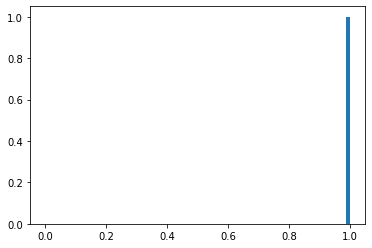

In [12]:
weights = np.ones_like(fedelity)/float(len(fedelity))
plt.hist(fedelity, bins=75, weights=weights, range=[0, 1])
plt.show()

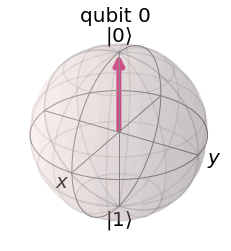

In [13]:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [14]:
#Kullback Leibler divergence
P_I=np.histogram(fedelity, bins=75, weights=weights, range=[0, 1])[0]
P_harr=[1/75]*75
P_I*np.log(P_I/P_harr)

<ipython-input-14-0d7a507abaab>:4: RuntimeWarning: divide by zero encountered in log
  P_I*np.log(P_I/P_harr)
<ipython-input-14-0d7a507abaab>:4: RuntimeWarning: invalid value encountered in multiply
  P_I*np.log(P_I/P_harr)


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 4.31748

## Circuit A

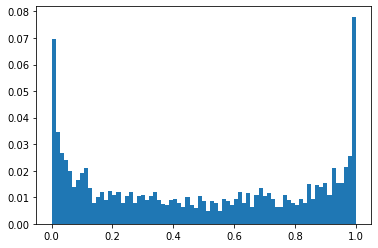

In [15]:

j=(-1)**(1/2)

backend = Aer.get_backend('qasm_simulator')
nshot=1000
nparam=2000
fedelity=[]    
for x in range(nparam):
    th1=2*pi*random()
    th2=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    qc.rz(th1, qr[0])
    qc.rz(th2, qr[0])
    qc.h(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0

    
    fedelity.append(ratio)
    
weights = np.ones_like(fedelity)/float(len(fedelity))
plt.hist(fedelity, bins=75, weights=weights)
plt.show()

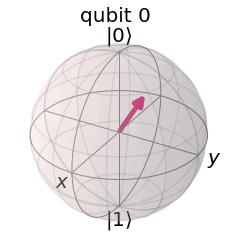

In [16]:
th=2*pi*random()
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.rz(th, qr[0])
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [17]:
#Kullback Leibler divergence
P_A=np.histogram(fedelity, bins=75, weights=weights, range=[0, 1])[0]
P_harr=[1/75]*75
sum(P_A*np.log(P_A/P_harr))

0.21734093145730315

## Circuit B

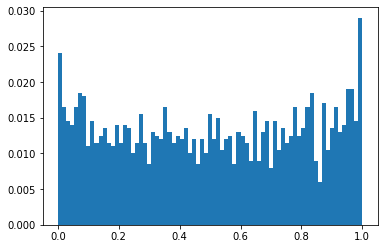

In [18]:
backend = Aer.get_backend('qasm_simulator')
nshot=1000
nparam=2000
fedelity=[]    
for x in range(nparam):
    th1=2*pi*random()
    th2=2*pi*random()
    
    th3=2*pi*random()
    th4=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    qc.rz(th1, qr[0])
    qc.rx(th2, qr[0])
    
    qc.rx(-th3, qr[0])

    qc.rz(-th4, qr[0])
    qc.h(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    
    fedelity.append(ratio)
    
weights = np.ones_like(fedelity)/float(len(fedelity))
plt.hist(fedelity, bins=75, weights=weights)
plt.show()

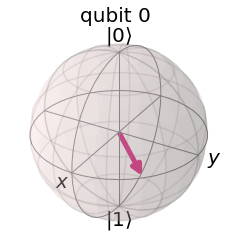

In [19]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
th1=pi/4
th2=0*pi/6
qc.h(qr[0])
qc.rz(th1, qr[0])
qc.rx(th2, qr[0])
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [20]:
#Kullback Leibler divergence
P_B=np.histogram(fedelity, bins=75, weights=weights, range=[0, 1])[0]
P_harr=[1/75]*75
sum(P_B*np.log(P_B/P_harr))

0.03217154537408286

## Arbitary Unitary

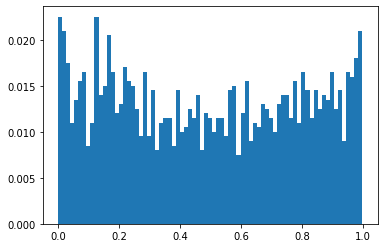

In [21]:
backend = Aer.get_backend('qasm_simulator')
nshot=1000
nparam=2000
fedelity=[]    
for x in range(nparam):
    th1=2*pi*random()
    th2=2*pi*random()
    th3=2*pi*random()
    th4=2*pi*random()
    th5=2*pi*random()
    th6=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.u3(th1,th2,th3, qr[0])
    qc.u3(-th4,-th5,-th6, qr[0])


    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    
    fedelity.append(ratio)
    
weights = np.ones_like(fedelity)/float(len(fedelity))
plt.hist(fedelity, bins=75, weights=weights)
plt.show()

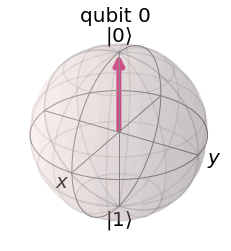

In [22]:
import numpy
from qiskit.circuit.controlledgate import ControlledGate
from qiskit.circuit.gate import Gate
from qiskit.circuit.quantumregister import QuantumRegister

svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

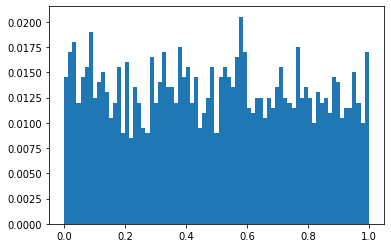

In [23]:
backend = Aer.get_backend('qasm_simulator')
nshot=1000
nparam=2000
fedelity=[]    
for x in range(nparam):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    u13=UnitaryGate(random_unitary(2))
    qc.append(u13, [qr[0]] )
    u13=UnitaryGate(random_unitary(2))
    qc.append(u13, [qr[0]] )

    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    
    fedelity.append(ratio)
    
weights = np.ones_like(fedelity)/float(len(fedelity))
plt.hist(fedelity, bins=75, weights=weights)
plt.show()

In [24]:
#Kullback Leibler divergence
P_U=np.histogram(fedelity, bins=75, weights=weights, range=[0, 1])[0]
P_harr=[1/75]*75
sum(P_U*np.log(P_U/P_harr))

0.02045493387826689